In [ ]:
!pip install networkx
!pip install torch-geometric
!pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 16.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the fol

In [ ]:
import numpy as np
import pandas as pd
import random
import torch
import torch_geometric

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import community as community_louvain
import torch.nn.functional as F


from torch import Tensor
from torch_geometric.nn import GCNConv, GATConv
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
from scipy.stats import ttest_ind

print("Torch version:", torch.__version__)
print("Torch Geometric version:", torch_geometric.__version__)


Torch version: 2.6.0+cu124
Torch Geometric version: 2.6.1


In [ ]:
elliptic_txs_features = pd.read_csv("/content/elliptic_txs_features.csv", header=None)
elliptic_txs_classes  = pd.read_csv("/content/elliptic_txs_classes.csv")
elliptic_txs_edgelist = pd.read_csv("/content/elliptic_txs_edgelist.csv")

elliptic_txs_features.columns = ['txId'] + [f'V{i}' for i in range(1, 167)]

print(f"""Shapes
{4*' '}Features : {elliptic_txs_features.shape[0]:8,} (rows)  {elliptic_txs_features.shape[1]:4,} (cols)
{4*' '}Classes  : {elliptic_txs_classes.shape[0]:8,} (rows)  {elliptic_txs_classes.shape[1]:4,} (cols)
{4*' '}Edgelist : {elliptic_txs_edgelist.shape[0]:8,} (rows)  {elliptic_txs_edgelist.shape[1]:4,} (cols)
""")

Shapes
    Features :    7,124 (rows)   167 (cols)
    Classes  :  203,769 (rows)     2 (cols)
    Edgelist :  234,355 (rows)     2 (cols)



Nodes & Edges

|
V
|
=
203
,
768
  (number of nodes in  G)

|
E
|
=
234
,
355
  (number of edges in G)

In [ ]:
elliptic_txs_features.head(3)   # Dataset containing the node features.

,txId,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792


In [ ]:
elliptic_txs_classes.head(3)  # Dataset containing the classes of the node.

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown


In [ ]:
elliptic_txs_edgelist.head(3)  # Dataset containing the edges.

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870


In [ ]:
elliptic_txs_classes['class_mapped'] = elliptic_txs_classes['class'].replace({'1': 'illicit', '2': 'licit'})

percentage_distribution = round(100 * elliptic_txs_classes['class_mapped'].value_counts(normalize=True), 2)
class_counts = elliptic_txs_classes['class_mapped'].value_counts()

emoji_mapping = {'licit': '✅', 'illicit': '❌', 'unknown': '🤷'}
elliptic_txs_classes['emoji'] = elliptic_txs_classes['class_mapped'].map(emoji_mapping)

classes_df = pd.DataFrame({
    'Class Mapped': elliptic_txs_classes['class_mapped'].unique(),
    'Class Raw': elliptic_txs_classes['class'].unique(),
    'Counts': class_counts.values,
    'Percentage': percentage_distribution.values,
    'Emoji': [emoji_mapping[class_label] for class_label in elliptic_txs_classes['class_mapped'].unique()]
})
classes_df

,Class Mapped,Class Raw,Counts,Percentage,Emoji
0,unknown,unknown,157205,77.15,🤷
1,licit,2,42019,20.62,✅
2,illicit,1,4545,2.23,❌


In [ ]:
num_nodes = elliptic_txs_features.shape[0]
num_edges = elliptic_txs_edgelist.shape[0]

print(f"Number of nodes: {num_nodes:,}")
print(f"Number of edges: {num_edges:,}")

Number of nodes: 7,124
Number of edges: 234,355


In [ ]:
# Create graph from the edgelist.
G = nx.from_pandas_edgelist(elliptic_txs_edgelist, 'txId1', 'txId2')

In [ ]:
RANDOM_STATE = 42
NUM_EPOCHS = 100

In [ ]:
# Sampling for easier analysis...for now.
classes_sampled = elliptic_txs_classes.groupby('class_mapped').sample(frac=0.05, random_state=RANDOM_STATE)
txIds_sampled = classes_sampled['txId']

# Filter elliptic_txs_edgelist based on the sampled txIds
edgelist_sampled = elliptic_txs_edgelist[
    elliptic_txs_edgelist['txId1'].isin(txIds_sampled) | elliptic_txs_edgelist['txId2'].isin(txIds_sampled)
]

# Filter elliptic_txs_features based on the sampled txIds
features_sampled = elliptic_txs_features[elliptic_txs_features['txId'].isin(txIds_sampled)]

print(f"Sampled Classes:\n{classes_sampled['class_mapped'].value_counts()}\n")
print(f"Sampled Edgelist: {edgelist_sampled.shape[0]:,}")
print(f"Sampled Features: {features_sampled.shape[0]:,}")

Sampled Classes:
class_mapped
unknown    7860
licit      2101
illicit     227
Name: count, dtype: int64

Sampled Edgelist: 23,051
Sampled Features: 344


# **Graph Connectivity**

In [ ]:
# Create graph from the edgelist.
G = nx.from_pandas_edgelist(edgelist_sampled, 'txId1', 'txId2')

Number of connected components: 7297
Giant component - Number of nodes: 400
Giant component - Number of edges: 431


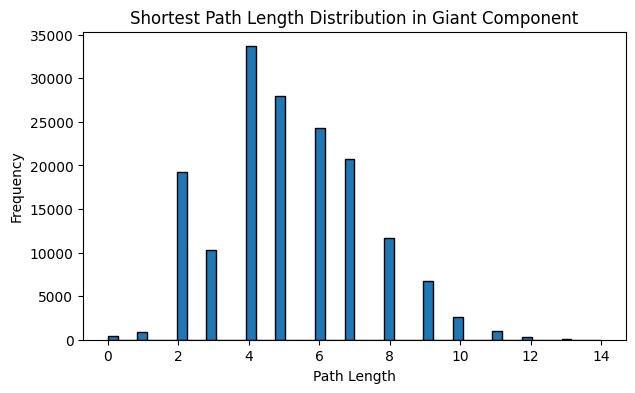

In [ ]:
# --- Connected components ---
num_connected_components = nx.number_connected_components(G)
print(f"Number of connected components: {num_connected_components}")

# --- Giant component analysis ---
giant_component = max(nx.connected_components(G), key=len)
G_giant = G.subgraph(giant_component)

print(f"Giant component - Number of nodes: {G_giant.number_of_nodes():,}")
print(f"Giant component - Number of edges: {G_giant.number_of_edges():,}")


# --------------------------------------------------------- #
# Shortest paths length distribution in the giant component #
# --------------------------------------------------------- #
path_lengths = dict(nx.shortest_path_length(G_giant))
path_lengths_values = [length for target_lengths in path_lengths.values() for length in target_lengths.values()]

plt.figure(figsize=(7, 4))
plt.hist(path_lengths_values, bins=50, edgecolor='black')
plt.title('Shortest Path Length Distribution in Giant Component')
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.show()

# **Node Centrality Measures**

In [ ]:
# Degree centrality.
degree_centrality = nx.degree_centrality(G_giant)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_degree_centrality = pd.DataFrame(top_degree_centrality, columns=['Node', 'Degree Centrality'])

print("Top 10 nodes by degree centrality:")
print("==================================")
print(df_top_degree_centrality)

top_nodes_by_ = df_top_degree_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_)
node_color = [degree_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

# -------- #
# Plotting #
# -------- #
# plt.figure(figsize=(7, 3))

# nx.draw(subgraph, with_labels=True, node_size=300, edge_color='gray', font_size=8,
#         node_color=node_color_normalized, cmap=cmap)
# plt.title('Top 10 Degree Centrality Nodes')
# plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Degree Centrality',ax=plt.gca() )
# plt.show()

Top 10 nodes by degree centrality:
        Node  Degree Centrality
0   22837965           0.275689
1   22837835           0.192982
2  279199578           0.030075
3    3807285           0.027569
4  279187194           0.027569
5   22837973           0.022556
6   90716926           0.022556
7    8128388           0.022556
8   22837808           0.020050
9   22838007           0.020050


In [ ]:
# Betweenness centrality.
betweenness_centrality = nx.betweenness_centrality(G_giant)
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_betweenness_centrality = pd.DataFrame(top_betweenness_centrality, columns=['Node', 'Betweenness Centrality'])

print("Top 10 nodes by betweenness centrality:")
print("=======================================")
print(df_top_betweenness_centrality)

top_nodes_by_ = df_top_betweenness_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_)
node_color = [betweenness_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

# -------- #
# Plotting #
# -------- #
# plt.figure(figsize=(7, 3))

# nx.draw(subgraph, with_labels=True, node_size=300, edge_color='gray', font_size=8,
#         node_color=node_color_normalized, cmap=cmap)
# plt.title('Top 10 Betweenness Centrality Nodes')
# plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Betweenness Centrality',ax=plt.gca() )
# plt.show()

Top 10 nodes by betweenness centrality:
        Node  Betweenness Centrality
0   22837835                0.553959
1   22837965                0.491607
2   90716926                0.166458
3   22837784                0.165590
4  279187194                0.164591
5    3807285                0.144993
6    3097782                0.113509
7    8128388                0.103709
8    1435388                0.092219
9   21296808                0.086872


In [ ]:
# Closeness centrality.
closeness_centrality = nx.closeness_centrality(G_giant)
top_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_closeness_centrality = pd.DataFrame(top_closeness_centrality, columns=['Node', 'Closeness Centrality'])

print("Top 10 nodes by closeness centrality:")
print("=====================================")
print(df_top_closeness_centrality)

top_nodes_by_closeness = df_top_closeness_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_closeness)
node_color = [closeness_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

# -------- #
# Plotting #
# -------- #
# plt.figure(figsize=(7, 3))

# nx.draw(subgraph, with_labels=True, node_size=300, edge_color='gray', font_size=8,
#         node_color=node_color_normalized, cmap=cmap)
# plt.title('Top 10 Closeness Centrality Nodes')
# plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Closeness Centrality',ax=plt.gca() )
# plt.show()

Top 10 nodes by closeness centrality:
        Node  Closeness Centrality
0   22837835              0.317928
1   22837965              0.293814
2    2203811              0.290605
3    1805107              0.285817
4   11447640              0.285817
5    2205152              0.285817
6    1367537              0.285817
7    1437191              0.285817
8   21296808              0.274038
9  279187194              0.271613


# **Graph Visualization**

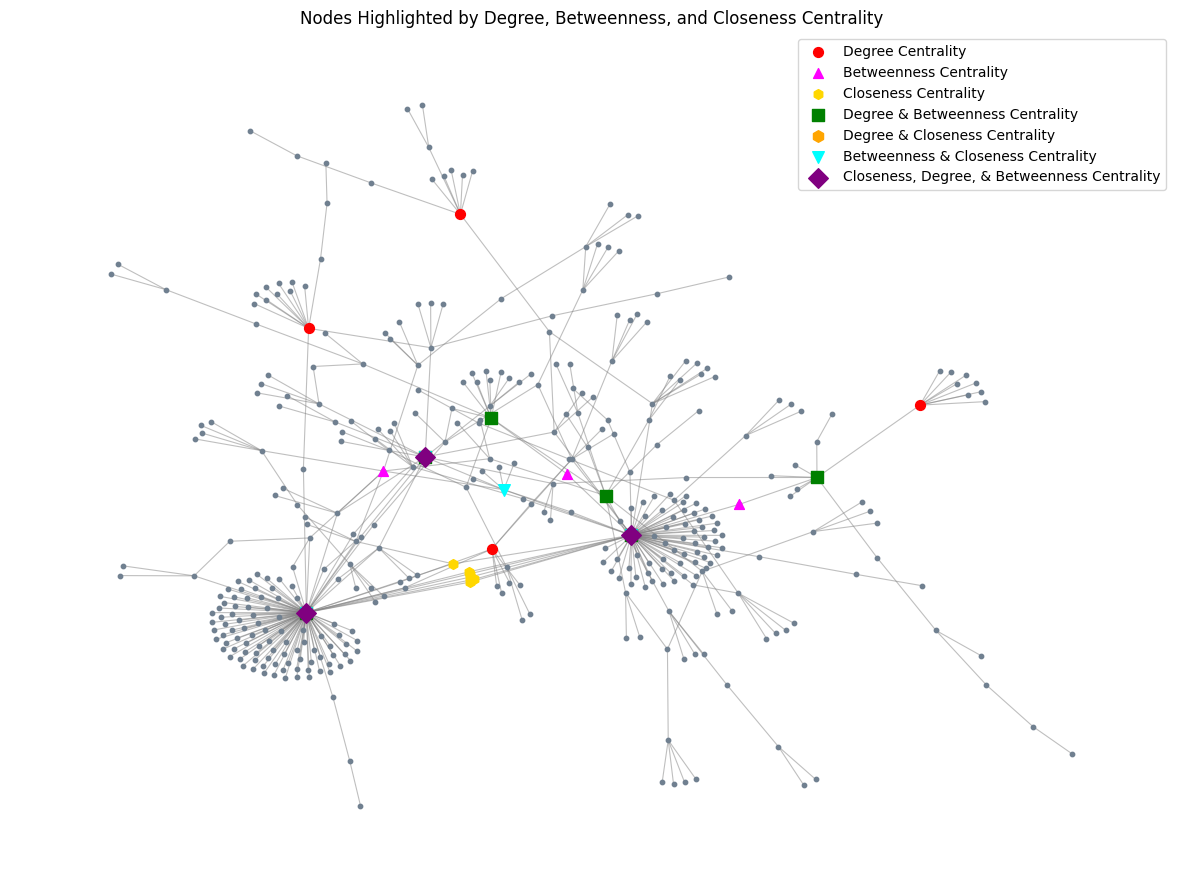

In [ ]:
# --------- #
# Preparing #
# --------- #

# Identify nodes that are top in each centrality measure and their combinations.
top_nodes_degree = set([node for node, _ in top_degree_centrality])
top_nodes_betweenness = set([node for node, _ in top_betweenness_centrality])
top_nodes_closeness = set([node for node, _ in top_closeness_centrality])

top_nodes_both = top_nodes_degree.intersection(top_nodes_betweenness)
top_nodes_closeness_and_degree = top_nodes_closeness.intersection(top_nodes_degree)
top_nodes_closeness_and_betweenness = top_nodes_closeness.intersection(top_nodes_betweenness)
top_nodes_all_three = top_nodes_closeness.intersection(top_nodes_degree).intersection(top_nodes_betweenness)

# Assign colors and shapes based on centrality measures.
node_color = []
node_shape = []

for node in G_giant.nodes():
    if node in top_nodes_all_three:
        node_color.append('purple')
        node_shape.append('D')
    elif node in top_nodes_closeness_and_degree:
        node_color.append('orange')
        node_shape.append('h')
    elif node in top_nodes_closeness_and_betweenness:
        node_color.append('cyan')
        node_shape.append('v')
    elif node in top_nodes_both:
        node_color.append('green')
        node_shape.append('s')
    elif node in top_nodes_degree:
        node_color.append('red')
        node_shape.append('o')
    elif node in top_nodes_betweenness:
        node_color.append('magenta')
        node_shape.append('^')
    elif node in top_nodes_closeness:
        node_color.append('yellow')
        node_shape.append('h')
    else:
        node_color.append('slategrey')
        node_shape.append('o')

# -------- #
# Plotting #
# -------- #

plt.figure(figsize=(15, 11))

pos = nx.spring_layout(G_giant)
# Draw all nodes first.
nx.draw_networkx_nodes(G_giant, pos, node_color='slategrey', node_size=10)

# Draw nodes with specific centrality measures.
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_degree - top_nodes_both - top_nodes_closeness_and_degree),
                       node_color='red', node_size=50, node_shape='o',
                       label='Degree Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_betweenness - top_nodes_both - top_nodes_closeness_and_betweenness),
                       node_color='magenta', node_size=50, node_shape='^',
                       label='Betweenness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_closeness - top_nodes_closeness_and_degree - top_nodes_closeness_and_betweenness),
                       node_color='gold', node_size=50, node_shape='h',
                       label='Closeness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_both),
                       node_color='green', node_size=80, node_shape='s',
                       label='Degree & Betweenness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_closeness_and_degree),
                       node_color='orange', node_size=70, node_shape='h',
                       label='Degree & Closeness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_closeness_and_betweenness),
                       node_color='cyan', node_size=70, node_shape='v',
                       label='Betweenness & Closeness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_all_three),
                       node_color='purple', node_size=100, node_shape='D',
                       label='Closeness, Degree, & Betweenness Centrality')

# Draw edges.
nx.draw_networkx_edges(G_giant, pos, width=0.8, edge_color='gray', alpha=0.5)

plt.axis('off')
plt.title('Nodes Highlighted by Degree, Betweenness, and Closeness Centrality')
plt.legend(scatterpoints=1)
plt.show()


# **Graph Neural Networks**

In [ ]:
# --------------------------------------------------------- #
# Create mapping with txId as key and actual index as value #
# --------------------------------------------------------- #

tx_id_mapping = {tx_id: idx for idx, tx_id in enumerate(elliptic_txs_features['txId'])}

edges_with_features = elliptic_txs_edgelist[elliptic_txs_edgelist['txId1'].isin(list(tx_id_mapping.keys()))\
                                          & elliptic_txs_edgelist['txId2'].isin(list(tx_id_mapping.keys()))]

edges_with_features['Id1'] = edges_with_features['txId1'].map(tx_id_mapping)
edges_with_features['Id2'] = edges_with_features['txId2'].map(tx_id_mapping)

edges_with_features


/tmp/ipython-input-19-3425247589.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_with_features['Id1'] = edges_with_features['txId1'].map(tx_id_mapping)
/tmp/ipython-input-19-3425247589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_with_features['Id2'] = edges_with_features['txId2'].map(tx_id_mapping)


,txId1,txId2,Id1,Id2
0,230425980,5530458,0,1
1,232022460,232438397,2,3
2,230460314,230459870,4,5
3,230333930,230595899,6,7
4,232013274,232029206,8,9
...,...,...,...,...
9159,230437620,230439288,3343,5961
9160,203465969,5986851,2757,5886
9161,232051667,232051672,4504,5962
9162,232364495,34300577,5963,1209


In [ ]:
edge_index = torch.tensor(edges_with_features[['Id1', 'Id2']].values.T, dtype=torch.long)
edge_index

tensor([[   0,    2,    4,  ..., 4504, 5963, 4243],
        [   1,    3,    5,  ..., 5962, 1209, 2744]])

In [ ]:
# ------------------------------------- #
# Save node features in suitable format #
# ------------------------------------- #

node_features = torch.tensor(elliptic_txs_features.drop(columns=['txId']).values,
                             dtype=torch.float)
print(node_features.shape)
node_features

elliptic_txs_classes['class'].value_counts()

torch.Size([7124, 166])


,count
class,
unknown,157205
2,42019
1,4545


In [ ]:
# ------------------------ #
# Labelencode target class #
# ------------------------ #

le = LabelEncoder()
class_labels = le.fit_transform(elliptic_txs_classes['class'])
node_labels = torch.tensor(class_labels, dtype=torch.long)
original_labels = le.inverse_transform(class_labels)

print(original_labels)
print(class_labels)
print(node_labels)

['unknown' 'unknown' 'unknown' ... '1' 'unknown' 'unknown']
[2 2 2 ... 0 2 2]
tensor([2, 2, 2,  ..., 0, 2, 2])


In [ ]:
# ------------------------------------ #
# Create pytorch geometric Data object #
# ------------------------------------ #

data = Data(x=node_features,
            edge_index=edge_index,
            y=node_labels)


known_mask   = (data.y == 0) | (data.y == 1)  # Only nodes with known labels licit or illicit
unknown_mask = data.y == 2                    # Nodes with unknown labels

# ------------------------------------------------ #
# Define size for Training, Validation and Testing #
# ------------------------------------------------ #

num_known_nodes = known_mask.sum().item()
permutations = torch.randperm(num_known_nodes)
train_size = int(0.8 * num_known_nodes)
val_size = int(0.1 * num_known_nodes)
test_size = num_known_nodes - train_size - val_size

total = np.sum([train_size, val_size, test_size])

print(f"""Number of observations per split
    Training   : {train_size:10,} ({100*train_size/total:0.2f} %)
    Validation : {val_size:10,} ({100*val_size/total:0.2f} %)
    Testing    : {test_size:10,} ({100*test_size/total:0.2f} %)
""")

Number of observations per split
    Training   :     37,251 (80.00 %)
    Validation :      4,656 (10.00 %)
    Testing    :      4,657 (10.00 %)



In [ ]:
# ----------------------------------------------- #
# Create mask for the indices of Train, Val, Test #
# ----------------------------------------------- #

data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

num_known_nodes_filtered = known_mask.nonzero(as_tuple=True)[0].size(0)
permutations = torch.randperm(num_known_nodes_filtered)

train_indices = known_mask.nonzero(as_tuple=True)[0][permutations[:train_size]]
val_indices = known_mask.nonzero(as_tuple=True)[0][permutations[train_size:train_size + val_size]]
test_indices = known_mask.nonzero(as_tuple=True)[0][permutations[train_size + val_size:]]

data.train_mask[train_indices] = True
data.val_mask[val_indices] = True
data.test_mask[test_indices] = True

data.train_mask

tensor([False, False, False,  ..., False, False, False])

In [ ]:
metrics_per_gnn = {
    'gcn': {
        'val': {
            'precisions': [],
            'probas': [],
        },
        'test': {
            'licit': {
                'probas': []
            },
            'illicit': {
                'probas': []
            },
        }
    },
    'gat': {
        'val': {
            'precisions': [],
            'probas': [],
        },
        'test': {
            'licit': {
                'probas': []
            },
            'illicit': {
                'probas': []
            },
        }
    },
    'gin': {
        'val': {
            'precisions': [],
            'probas': [],
        },
        'test': {
            'licit': {
                'probas': []
            },
            'illicit': {
                'probas': []
            },
        }
    }
}

In [ ]:
# ------------------------------------------- #
# Training, Evaluation and prediction methods #
# ------------------------------------------- #

def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)

        correct = (pred[mask] == data.y[mask]).sum().item()
        accuracy = correct / mask.sum().item()

        y_true = data.y[mask].cpu().numpy()
        y_pred = pred[mask].cpu().numpy()

        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

    return metrics

def predict(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
    return pred

def predict_probabilities(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        probabilities = torch.exp(out)
    return probabilities


def train_gnn(num_epochs, data, model, optimizer, criterion):

    train_losses = []
    train_accuracies = []
    train_precisions = []
    train_recalls = []
    train_f1_scores = []

    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1_scores = []

    # ----- #
    # Train #
    # ----- #

    for epoch in range(1, num_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask],
                         data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # --- Calculate training metrics ---
        pred_train = out[data.train_mask].argmax(dim=1)
        correct_train = (pred_train == data.y[data.train_mask]).sum()
        train_acc = int(correct_train) / int(data.train_mask.sum())
        train_accuracies.append(train_acc)

        y_true_train = data.y[data.train_mask].cpu().numpy()
        y_pred_train = pred_train.cpu().numpy()

        train_prec = precision_score(y_true_train, y_pred_train, average='weighted', zero_division=0)
        train_rec = recall_score(y_true_train, y_pred_train, average='weighted', zero_division=0)
        train_f1 = f1_score(y_true_train, y_pred_train, average='weighted', zero_division=0)

        train_precisions.append(train_prec)
        train_recalls.append(train_rec)
        train_f1_scores.append(train_f1)
        train_losses.append(loss.item())

        # --- Validate and calculate validation metrics ---
        model.eval()
        with torch.no_grad():
            out = model(data)
            pred_val = out[data.val_mask].argmax(dim=1)
            correct_val = (pred_val == data.y[data.val_mask]).sum()
            val_acc = int(correct_val) / int(data.val_mask.sum())
            val_accuracies.append(val_acc)

            y_true_val = data.y[data.val_mask].cpu().numpy()
            y_pred_val = pred_val.cpu().numpy()

            val_prec = precision_score(y_true_val, y_pred_val, average='weighted', zero_division=0)
            val_rec = recall_score(y_true_val, y_pred_val, average='weighted', zero_division=0)
            val_f1 = f1_score(y_true_val, y_pred_val, average='weighted', zero_division=0)

            val_precisions.append(val_prec)
            val_recalls.append(val_rec)
            val_f1_scores.append(val_f1)

        if epoch % 10 == 0:
            print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Train - Acc: {train_acc:.4f} - Prec: {train_prec:.4f} - Rec: {train_rec:.4f} - F1: {train_f1:.4f}')
            print(f'                         Val   - Acc: {val_acc:.4f} - Prec: {val_prec:.4f} - Rec: {val_rec:.4f} - F1: {val_f1:.4f}')

    return {
        'train': {
            'losses': train_losses,
            'accuracies': train_accuracies,
            'precisions': train_precisions,
            'recalls': train_recalls,
            'f1_scores': train_f1_scores,
        },
        'val': {
            'accuracies': val_accuracies,
            'precisions': val_precisions,
            'recalls': val_recalls,
            'f1_scores': val_f1_scores,
        }
    }



# **GCN - Graph Convolutional Networks**

In [ ]:
# -------------- #
# Define the GCN #
# -------------- #

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


# ---------- #
# Initialize #
# ---------- #

model = GCN(num_node_features=data.num_features, num_classes=len(le.classes_))
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.01,
                             weight_decay=0.0005)
criterion = torch.nn.CrossEntropyLoss()  # Since we have a multiclass classification problem.



In [ ]:
# ----- #
# Train #
# ----- #

train_val_metrics = train_gnn(NUM_EPOCHS,
                              data,
                              model,
                              optimizer,
                              criterion)

metrics_per_gnn['gcn']['val']['precisions'] = train_val_metrics['val']['precisions']

Epoch 010, Loss: 0.3818, Train - Acc: 0.8953 - Prec: 0.8489 - Rec: 0.8953 - F1: 0.8616
                         Val   - Acc: 0.9036 - Prec: 0.8554 - Rec: 0.9036 - F1: 0.8684
Epoch 020, Loss: 0.3509, Train - Acc: 0.9055 - Prec: 0.8806 - Rec: 0.9055 - F1: 0.8739
                         Val   - Acc: 0.9147 - Prec: 0.8954 - Rec: 0.9147 - F1: 0.8917
Epoch 030, Loss: 0.2773, Train - Acc: 0.8894 - Prec: 0.8935 - Rec: 0.8894 - F1: 0.8914
                         Val   - Acc: 0.8918 - Prec: 0.8983 - Rec: 0.8918 - F1: 0.8948
Epoch 040, Loss: 0.2402, Train - Acc: 0.9107 - Prec: 0.8972 - Rec: 0.9107 - F1: 0.9011
                         Val   - Acc: 0.9173 - Prec: 0.9033 - Rec: 0.9173 - F1: 0.9065
Epoch 050, Loss: 0.2245, Train - Acc: 0.9129 - Prec: 0.8988 - Rec: 0.9129 - F1: 0.8881
                         Val   - Acc: 0.9175 - Prec: 0.9017 - Rec: 0.9175 - F1: 0.8956
Epoch 060, Loss: 0.2105, Train - Acc: 0.9185 - Prec: 0.9074 - Rec: 0.9185 - F1: 0.8993
                         Val   - Acc: 0.921

In [ ]:

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64)
        self.conv2 = GCNConv(64, 32)
        self.conv3 = GCNConv(32, 16)
        self.conv4 = GCNConv(16, num_classes)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)



In [ ]:
model = GCN(num_node_features=data.num_features, num_classes=len(le.classes_))
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0005)
criterion = torch.nn.CrossEntropyLoss()


# ----- #
# Train #
# ----- #
#
train_val_metrics = train_gnn(NUM_EPOCHS,
                              data,
                              model,
                              optimizer,
                              criterion)

metrics_per_gnn['gcn']['val']['precisions'] = train_val_metrics['val']['precisions']

Epoch 010, Loss: 0.2776, Train - Acc: 0.8941 - Prec: 0.8401 - Rec: 0.8941 - F1: 0.8581
                         Val   - Acc: 0.9006 - Prec: 0.8562 - Rec: 0.9006 - F1: 0.8699
Epoch 020, Loss: 0.2453, Train - Acc: 0.8996 - Prec: 0.8626 - Rec: 0.8996 - F1: 0.8681
                         Val   - Acc: 0.9074 - Prec: 0.8736 - Rec: 0.9074 - F1: 0.8756
Epoch 030, Loss: 0.2308, Train - Acc: 0.9082 - Prec: 0.8870 - Rec: 0.9082 - F1: 0.8864
                         Val   - Acc: 0.9192 - Prec: 0.9041 - Rec: 0.9192 - F1: 0.9011
Epoch 040, Loss: 0.2186, Train - Acc: 0.9129 - Prec: 0.9020 - Rec: 0.9129 - F1: 0.8859
                         Val   - Acc: 0.9188 - Prec: 0.9054 - Rec: 0.9188 - F1: 0.8963
Epoch 050, Loss: 0.2087, Train - Acc: 0.9197 - Prec: 0.9109 - Rec: 0.9197 - F1: 0.8999
                         Val   - Acc: 0.9246 - Prec: 0.9148 - Rec: 0.9246 - F1: 0.9070
Epoch 060, Loss: 0.1997, Train - Acc: 0.9249 - Prec: 0.9176 - Rec: 0.9249 - F1: 0.9092
                         Val   - Acc: 0.928

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.nn import BatchNorm1d, Dropout

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()

        self.conv1 = GCNConv(num_node_features, 64)
        self.bn1 = BatchNorm1d(64)

        self.conv2 = GCNConv(64, 64)
        self.bn2 = BatchNorm1d(64)

        self.conv3 = GCNConv(64, 32)
        self.bn3 = BatchNorm1d(32)

        self.conv4 = GCNConv(32, num_classes)

        self.dropout = Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x1 = F.relu(self.bn1(self.conv1(x, edge_index)))
        x1 = self.dropout(x1)

        x2 = F.relu(self.bn2(self.conv2(x1, edge_index) + x1))  # Residual
        x2 = self.dropout(x2)

        x3 = F.relu(self.bn3(self.conv3(x2, edge_index)))
        x3 = self.dropout(x3)

        out = self.conv4(x3, edge_index)

        return F.log_softmax(out, dim=1)


In [ ]:

model = GCN(num_node_features=data.num_features, num_classes=len(le.classes_))
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0005)
criterion = torch.nn.CrossEntropyLoss()

# ----- #
# Train #
# ----- #
#
train_val_metrics = train_gnn(NUM_EPOCHS,
                              data,
                              model,
                              optimizer,
                              criterion)

metrics_per_gnn['gcn']['val']['precisions'] = train_val_metrics['val']['precisions']

Epoch 010, Loss: 0.5968, Train - Acc: 0.7638 - Prec: 0.8727 - Rec: 0.7638 - F1: 0.8068
                         Val   - Acc: 0.9018 - Prec: 0.8804 - Rec: 0.9018 - F1: 0.8869
Epoch 020, Loss: 0.3610, Train - Acc: 0.8887 - Prec: 0.8518 - Rec: 0.8887 - F1: 0.8635
                         Val   - Acc: 0.8997 - Prec: 0.8832 - Rec: 0.8997 - F1: 0.8876
Epoch 030, Loss: 0.3058, Train - Acc: 0.8973 - Prec: 0.8594 - Rec: 0.8973 - F1: 0.8672
                         Val   - Acc: 0.9076 - Prec: 0.8778 - Rec: 0.9076 - F1: 0.8810
Epoch 040, Loss: 0.2805, Train - Acc: 0.9000 - Prec: 0.8653 - Rec: 0.9000 - F1: 0.8697
                         Val   - Acc: 0.9162 - Prec: 0.8984 - Rec: 0.9162 - F1: 0.8962
Epoch 050, Loss: 0.2645, Train - Acc: 0.9043 - Prec: 0.8799 - Rec: 0.9043 - F1: 0.8827
                         Val   - Acc: 0.9238 - Prec: 0.9125 - Rec: 0.9238 - F1: 0.9145
Epoch 060, Loss: 0.2519, Train - Acc: 0.9069 - Prec: 0.8853 - Rec: 0.9069 - F1: 0.8870
                         Val   - Acc: 0.924

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.nn import LayerNorm, Dropout

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()

        self.conv1 = GCNConv(num_node_features, 64)
        self.ln1 = LayerNorm(64)

        self.conv2 = GCNConv(64, 64)
        self.ln2 = LayerNorm(64)

        self.conv3 = GCNConv(64, 32)
        self.ln3 = LayerNorm(32)

        self.conv4 = GCNConv(32, num_classes)

        self.dropout = Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x1 = F.relu(self.ln1(self.conv1(x, edge_index)))
        x1 = self.dropout(x1)

        x2 = F.relu(self.ln2(self.conv2(x1, edge_index) + x1))  # Residual
        x2 = self.dropout(x2)

        x3 = F.relu(self.ln3(self.conv3(x2, edge_index)))
        x3 = self.dropout(x3)

        out = self.conv4(x3, edge_index)

        return F.log_softmax(out, dim=1)


In [ ]:
model = GCN(num_node_features=data.num_features, num_classes=len(le.classes_))
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0005)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
# ----- #
# Train #
# ----- #
#
train_val_metrics = train_gnn(NUM_EPOCHS,
                              data,
                              model,
                              optimizer,
                              criterion)

metrics_per_gnn['gcn']['val']['precisions'] = train_val_metrics['val']['precisions']

Epoch 010, Loss: 0.6504, Train - Acc: 0.7418 - Prec: 0.8800 - Rec: 0.7418 - F1: 0.7976
                         Val   - Acc: 0.8872 - Prec: 0.8816 - Rec: 0.8872 - F1: 0.8794
Epoch 020, Loss: 0.4061, Train - Acc: 0.8770 - Prec: 0.8559 - Rec: 0.8770 - F1: 0.8629
                         Val   - Acc: 0.8930 - Prec: 0.8758 - Rec: 0.8930 - F1: 0.8818
Epoch 030, Loss: 0.3398, Train - Acc: 0.8896 - Prec: 0.8540 - Rec: 0.8896 - F1: 0.8650
                         Val   - Acc: 0.9036 - Prec: 0.8750 - Rec: 0.9036 - F1: 0.8825
Epoch 040, Loss: 0.3000, Train - Acc: 0.8974 - Prec: 0.8717 - Rec: 0.8974 - F1: 0.8783
                         Val   - Acc: 0.9156 - Prec: 0.8994 - Rec: 0.9156 - F1: 0.9023
Epoch 050, Loss: 0.2813, Train - Acc: 0.8997 - Prec: 0.8750 - Rec: 0.8997 - F1: 0.8810
                         Val   - Acc: 0.9156 - Prec: 0.9076 - Rec: 0.9156 - F1: 0.9108
Epoch 060, Loss: 0.2612, Train - Acc: 0.9044 - Prec: 0.8884 - Rec: 0.9044 - F1: 0.8933
                         Val   - Acc: 0.916